In [41]:
from time import time

import matplotlib.pyplot as plt
from scipy.stats import loguniform

from sklearn.datasets import fetch_lfw_people
from sklearn.decomposition import PCA
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
# from sklearn.svm import SVC
from concrete.ml.sklearn.svm import LinearSVC

In [42]:
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape

# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)

Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7


In [43]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [57]:
n_components = 150

print(
    "Extracting the top %d eigenfaces from %d faces" % (n_components, X_train.shape[0])
)
t0 = time()
pca = PCA(n_components=n_components, svd_solver="randomized", whiten=True).fit(X_train)
print("done in %0.3fs" % (time() - t0))

eigenfaces = pca.components_.reshape((n_components, h, w))

print("Projecting the input data on the eigenfaces orthonormal basis")
t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print("done in %0.3fs" % (time() - t0))


Extracting the top 150 eigenfaces from 966 faces
done in 2.968s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.203s


In [58]:
# print("Fitting the classifier to the training set")
# t0 = time()
# param_grid = {
#     "C": loguniform(1e3, 1e5),
#     "gamma": loguniform(1e-4, 1e-1),
# }
# clf = RandomizedSearchCV(
#     SVC(kernel="rbf", class_weight="balanced"), param_grid, n_iter=10
# )

# clf = clf.fit(X_train_pca, y_train)
# print("done in %0.3fs" % (time() - t0))
# print("Best estimator found by grid search:")
# print(clf.best_estimator_)

In [59]:
from concrete.ml.sklearn.svm import LinearSVC
from scipy.stats import loguniform
from sklearn.model_selection import RandomizedSearchCV
from time import time

print("Fitting the classifier to the training set")
t0 = time()

# Define the parameter grid for LinearSVC
param_grid = {
    "C": loguniform(1e-3, 1e3),  # Adjusted range for C to suit LinearSVC
}

# Use Concrete ML's LinearSVC
clf = RandomizedSearchCV(
    LinearSVC(class_weight="balanced", max_iter=5000),  # Increased max_iter
    param_grid,
    n_iter=10
)
# Fit the model
clf = clf.fit(X_train_pca, y_train)

print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf.best_estimator_)

Fitting the classifier to the training set
done in 29.855s
Best estimator found by grid search:
LinearSVC(C=0.04660439874058365, class_weight='balanced', max_iter=5000)


Predicting people's names on the test set
done in 0.001s
                   precision    recall  f1-score   support

     Ariel Sharon       0.67      0.77      0.71        13
     Colin Powell       0.79      0.88      0.83        60
  Donald Rumsfeld       0.66      0.78      0.71        27
    George W Bush       0.95      0.86      0.91       146
Gerhard Schroeder       0.65      0.68      0.67        25
      Hugo Chavez       0.53      0.67      0.59        15
       Tony Blair       0.84      0.72      0.78        36

         accuracy                           0.82       322
        macro avg       0.73      0.77      0.74       322
     weighted avg       0.83      0.82      0.82       322



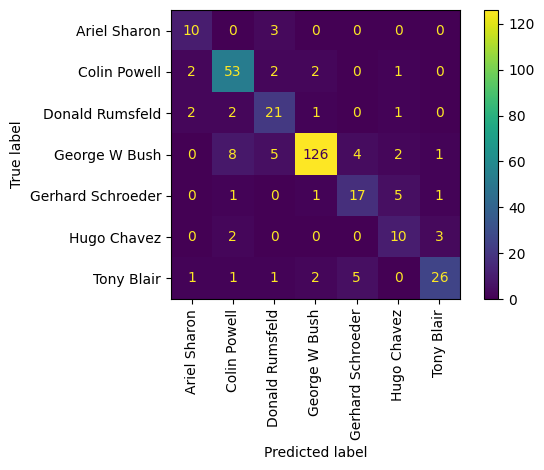

In [60]:
print("Predicting people's names on the test set")
t0 = time()
y_pred = clf.predict(X_test_pca)
print("done in %0.3fs" % (time() - t0))

print(classification_report(y_test, y_pred, target_names=target_names))
ConfusionMatrixDisplay.from_estimator(
    clf, X_test_pca, y_test, display_labels=target_names, xticks_rotation="vertical"
)
plt.tight_layout()
plt.show()

In [61]:
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=0.01, right=0.99, top=0.90, hspace=0.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

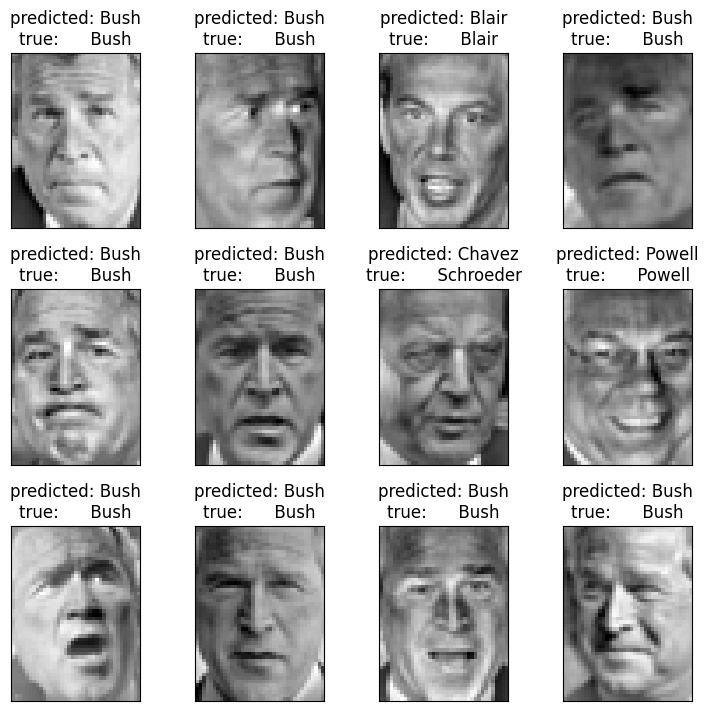

In [62]:
def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(" ", 1)[-1]
    true_name = target_names[y_test[i]].rsplit(" ", 1)[-1]
    return "predicted: %s\ntrue:      %s" % (pred_name, true_name)


prediction_titles = [
    title(y_pred, y_test, target_names, i) for i in range(y_pred.shape[0])
]

plot_gallery(X_test, prediction_titles, h, w)

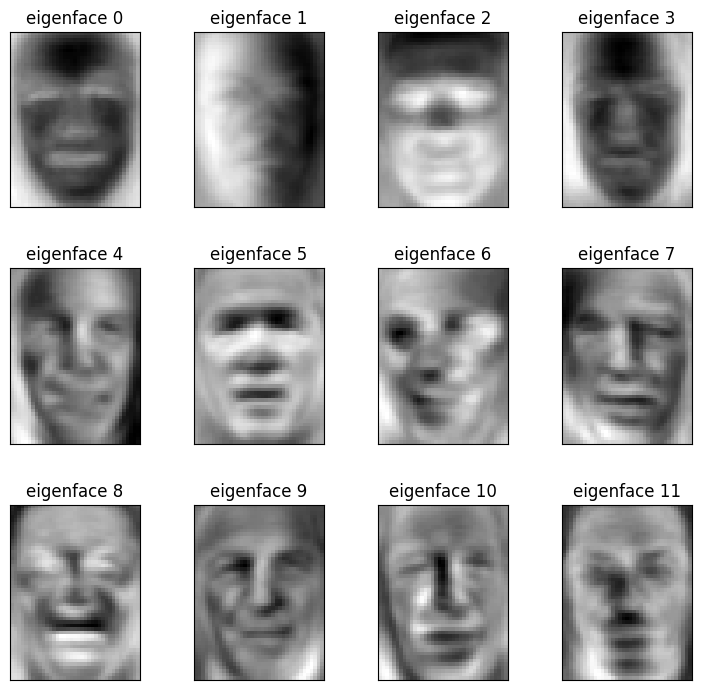

In [63]:
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

plt.show()

In [64]:
import os
import shutil
from concrete.ml.deployment import FHEModelClient

# Access the best estimator from RandomizedSearchCV
best_model = clf.best_estimator_

# Compile the model for encrypted inference
print("Compiling the model for encrypted inference...")
best_model.compile(X_train_pca)
print("Model compiled successfully!")


best_model.predict(X_test_pca[:5])



Compiling the model for encrypted inference...
Model compiled successfully!


[cctools-port]: generating fake signature for '/var/folders/c9/8rc_zy1n66b9fv9658s4z6g00000gn/T/tmpn89s1gx6/sharedlib.dylib'


array([3, 3, 6, 3, 3])

Performing predictions on the entire test set...
done in 0.003s
                   precision    recall  f1-score   support

     Ariel Sharon       0.67      0.77      0.71        13
     Colin Powell       0.79      0.88      0.83        60
  Donald Rumsfeld       0.66      0.78      0.71        27
    George W Bush       0.95      0.86      0.91       146
Gerhard Schroeder       0.65      0.68      0.67        25
      Hugo Chavez       0.53      0.67      0.59        15
       Tony Blair       0.84      0.72      0.78        36

         accuracy                           0.82       322
        macro avg       0.73      0.77      0.74       322
     weighted avg       0.83      0.82      0.82       322



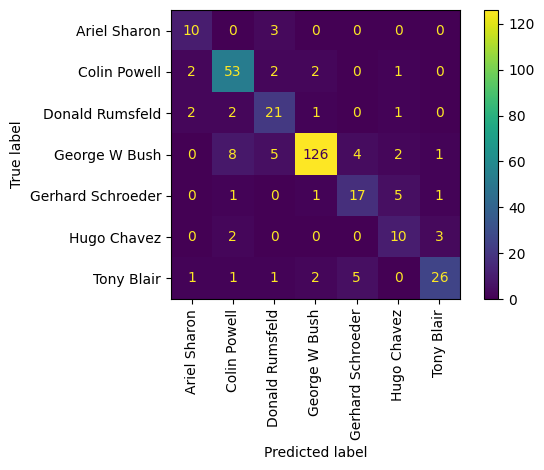

In [65]:
print("Performing predictions on the entire test set...")
t0 = time()

# Predict for the entire test set
y_pred = best_model.predict(X_test_pca)
print("done in %0.3fs" % (time() - t0))

# Evaluate the predictions
print(classification_report(y_test, y_pred, target_names=target_names))

# Display the confusion matrix
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred, display_labels=target_names, xticks_rotation="vertical"
)
plt.tight_layout()
plt.show()

Predicting people's names on the test set...
done in 0.002s


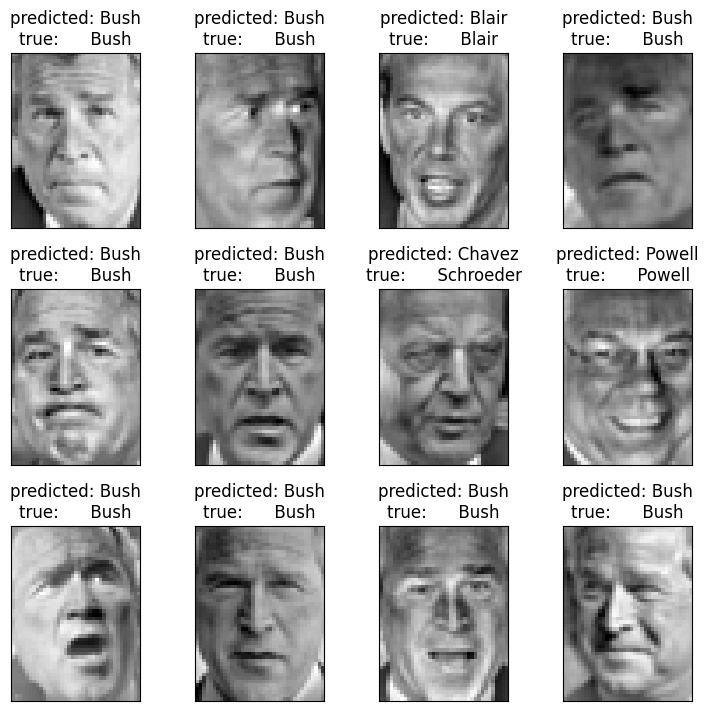

In [66]:

print("Predicting people's names on the test set...")
t0 = time()
y_pred = best_model.predict(X_test_pca)  # Predict for all test samples
print("done in %0.3fs" % (time() - t0))

# Generate titles for all predictions
prediction_titles = [
    title(y_pred, y_test, target_names, i) for i in range(y_pred.shape[0])
]

# Plot the gallery with predictions and true labels for all test samples
plot_gallery(X_test, prediction_titles, h, w)
plt.show()

In [67]:
from pathlib import Path
from concrete.ml.common.serialization.dumpers import dump

# Define the path to save the model
save_path = Path("./saved_model.json")

# Save the model to a JSON file
with save_path.open("w") as f:
    dump(best_model, f)

print(f"Model saved successfully to {save_path}")

Model saved successfully to saved_model.json


In [68]:
from pathlib import Path

dumped_model_path = Path("./saved_model_direct.json")

# Save the model to a JSON file using the model's dump method
with dumped_model_path.open("w") as f:
    best_model.dump(f)

print(f"Model saved successfully to {dumped_model_path}")

Model saved successfully to saved_model_direct.json


Model loaded and compiled successfully!


[cctools-port]: generating fake signature for '/var/folders/c9/8rc_zy1n66b9fv9658s4z6g00000gn/T/tmpy9k0dwh1/sharedlib.dylib'


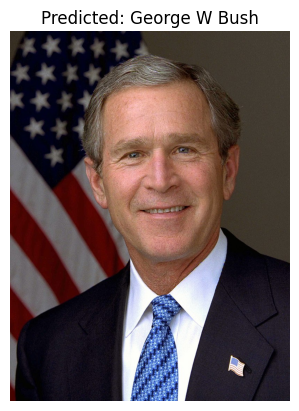

In [72]:
import cv2
import numpy as np
from pathlib import Path
from concrete.ml.common.serialization.loaders import load
from matplotlib import pyplot as plt

# Load the saved Concrete ML model
model_path = Path("./saved_model_direct.json")
with model_path.open("r") as f:
    model = load(f)

# Compile the model (required after loading)
# Replace `150` with the correct number of features used during training
sample_input = np.random.rand(1, 150)  # Correct number of features
model.compile(sample_input)

print("Model loaded and compiled successfully!")

# Define the image dimensions (must match the training data dimensions)
IMAGE_HEIGHT = 15  # Replace with the height of your training images
IMAGE_WIDTH = 10   # Replace with the width of your training images

# Define the target names (must match the training labels)
target_names = [
    "Ariel Sharon",
    "Colin Powell",
    "Donald Rumsfeld",
    "George W Bush",
    "Gerhard Schroeder",
    "Hugo Chavez",
    "Tony Blair",
]

def preprocess_image(image_path):
    """
    Preprocess the input image to match the model's input format.
    - Resize the image to the required dimensions.
    - Convert it to grayscale.
    - Flatten the image into a 1D array.
    """
    image = cv2.imread(image_path)
    resized_image = cv2.resize(image, (IMAGE_WIDTH, IMAGE_HEIGHT))
    grayscale_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)
    flattened_image = grayscale_image.flatten() / 255.0  # Normalize pixel values
    return flattened_image

def predict_president(image_path):
    """
    Predict the president in the given image using the loaded model.
    """
    preprocessed_image = preprocess_image(image_path)
    prediction = model.predict([preprocessed_image])  # Model expects a 2D array
    predicted_label = int(prediction[0])
    return target_names[predicted_label]

# Upload and predict
# Update the path to the uploaded image
uploaded_image_path = "./presidents/bush.jpeg"  # Path to the provided image

# Predict the president in the uploaded image
predicted_name = predict_president(uploaded_image_path)

# Display the uploaded image and prediction
image = cv2.imread(uploaded_image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB for displaying with matplotlib
plt.imshow(image)
plt.title(f"Predicted: {predicted_name}")
plt.axis("off")
plt.show()